LAB 13.3 Transformer – Hugging Face – BERT

2403A52007

M Rakshith


### Install Required Libraries

In [ ]:


!pip install transformers datasets -q

import torch
import numpy as np
import pandas as pd

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Load Dataset (IMDb)

In [ ]:
"""
STEP 3: Load IMDb Dataset
Binary Sentiment Classification (Positive / Negative)
"""

dataset = load_dataset("imdb")

print(dataset)
print("\nSample Record:\n")
print(dataset["train"][0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Sample Record:

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between askin

### Check Class Distribution

In [ ]:
"""
STEP 4: Check Class Distribution
"""

train_labels = dataset["train"]["label"]

unique, counts = np.unique(train_labels, return_counts=True)

print("Class Distribution:")
for u, c in zip(unique, counts):
    print(f"Label {u}:", c)

Class Distribution:
Label 0: 12500
Label 1: 12500


### Load BERT Tokenizer

In [ ]:
"""
STEP 5: Load Pretrained BERT Tokenizer
"""

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Tokenization Function

In [ ]:
"""
STEP 6: Tokenize Text
Apply padding and truncation
"""

def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Prepare Dataset for PyTorch

In [ ]:
"""
STEP 7: Convert Dataset to PyTorch Format
"""

tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

train_dataset = tokenized_dataset["train"]
test_dataset = tokenized_dataset["test"]

### Load Pretrained BERT Model

In [ ]:
"""
STEP 8: Load BERT Model for Classification
"""

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


### Define Evaluation Metrics

In [ ]:
"""
STEP 9: Define Evaluation Metrics
Accuracy, Precision, Recall, F1
"""

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="binary"
    )

    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

### Define Training Arguments

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


### Initialize Trainer

In [ ]:
"""
STEP 11: Initialize Trainer
"""

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

### Train Model

In [ ]:
"""
STEP 12: Train the Model
"""

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.300377,0.283295,0.882840,0.904557,0.856000,0.879609


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.300377,0.283295,0.882840,0.904557,0.856000,0.879609
2,0.172328,0.340464,0.892800,0.885158,0.902720,0.893853


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=3126, training_loss=0.24884199013102917, metrics={'train_runtime': 1744.7873, 'train_samples_per_second': 28.657, 'train_steps_per_second': 1.792, 'total_flos': 3328881072414720.0, 'train_loss': 0.24884199013102917, 'epoch': 2.0})

### Evaluate Model

In [ ]:
"""
STEP 13: Evaluate Model Performance
"""

results = trainer.evaluate()
print("\nEvaluation Results:\n", results)


Evaluation Results:
 {'eval_loss': 0.3404642641544342, 'eval_accuracy': 0.8928, 'eval_precision': 0.885158456228428, 'eval_recall': 0.90272, 'eval_f1': 0.8938529784537389, 'eval_runtime': 207.0862, 'eval_samples_per_second': 120.723, 'eval_steps_per_second': 7.548, 'epoch': 2.0}


### Generate Confusion Matrix

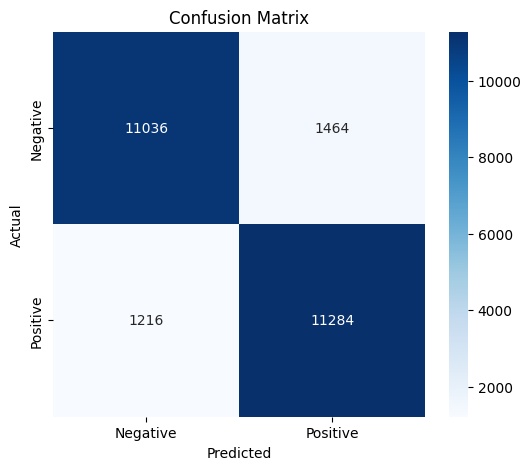

In [ ]:
"""
STEP 14: Confusion Matrix Heatmap
"""

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()